# 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

# 목차

## 1. Baseline

## 2. 랭킹 올리기

## 3. 직접 튜닝해 보기 

## 4. 회고

# 루브릭 평가기준

|  평가문항 | 상세기준  |
| :------------ | :------------ |
|  1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가? |  데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다. |
|2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?   | 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.  |
| 3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?  | 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.  |

# 1. Baseline

# 라이브러리

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 데이터 가져오기

In [40]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [41]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [42]:
y = data['price']

del data['price']

In [43]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [44]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

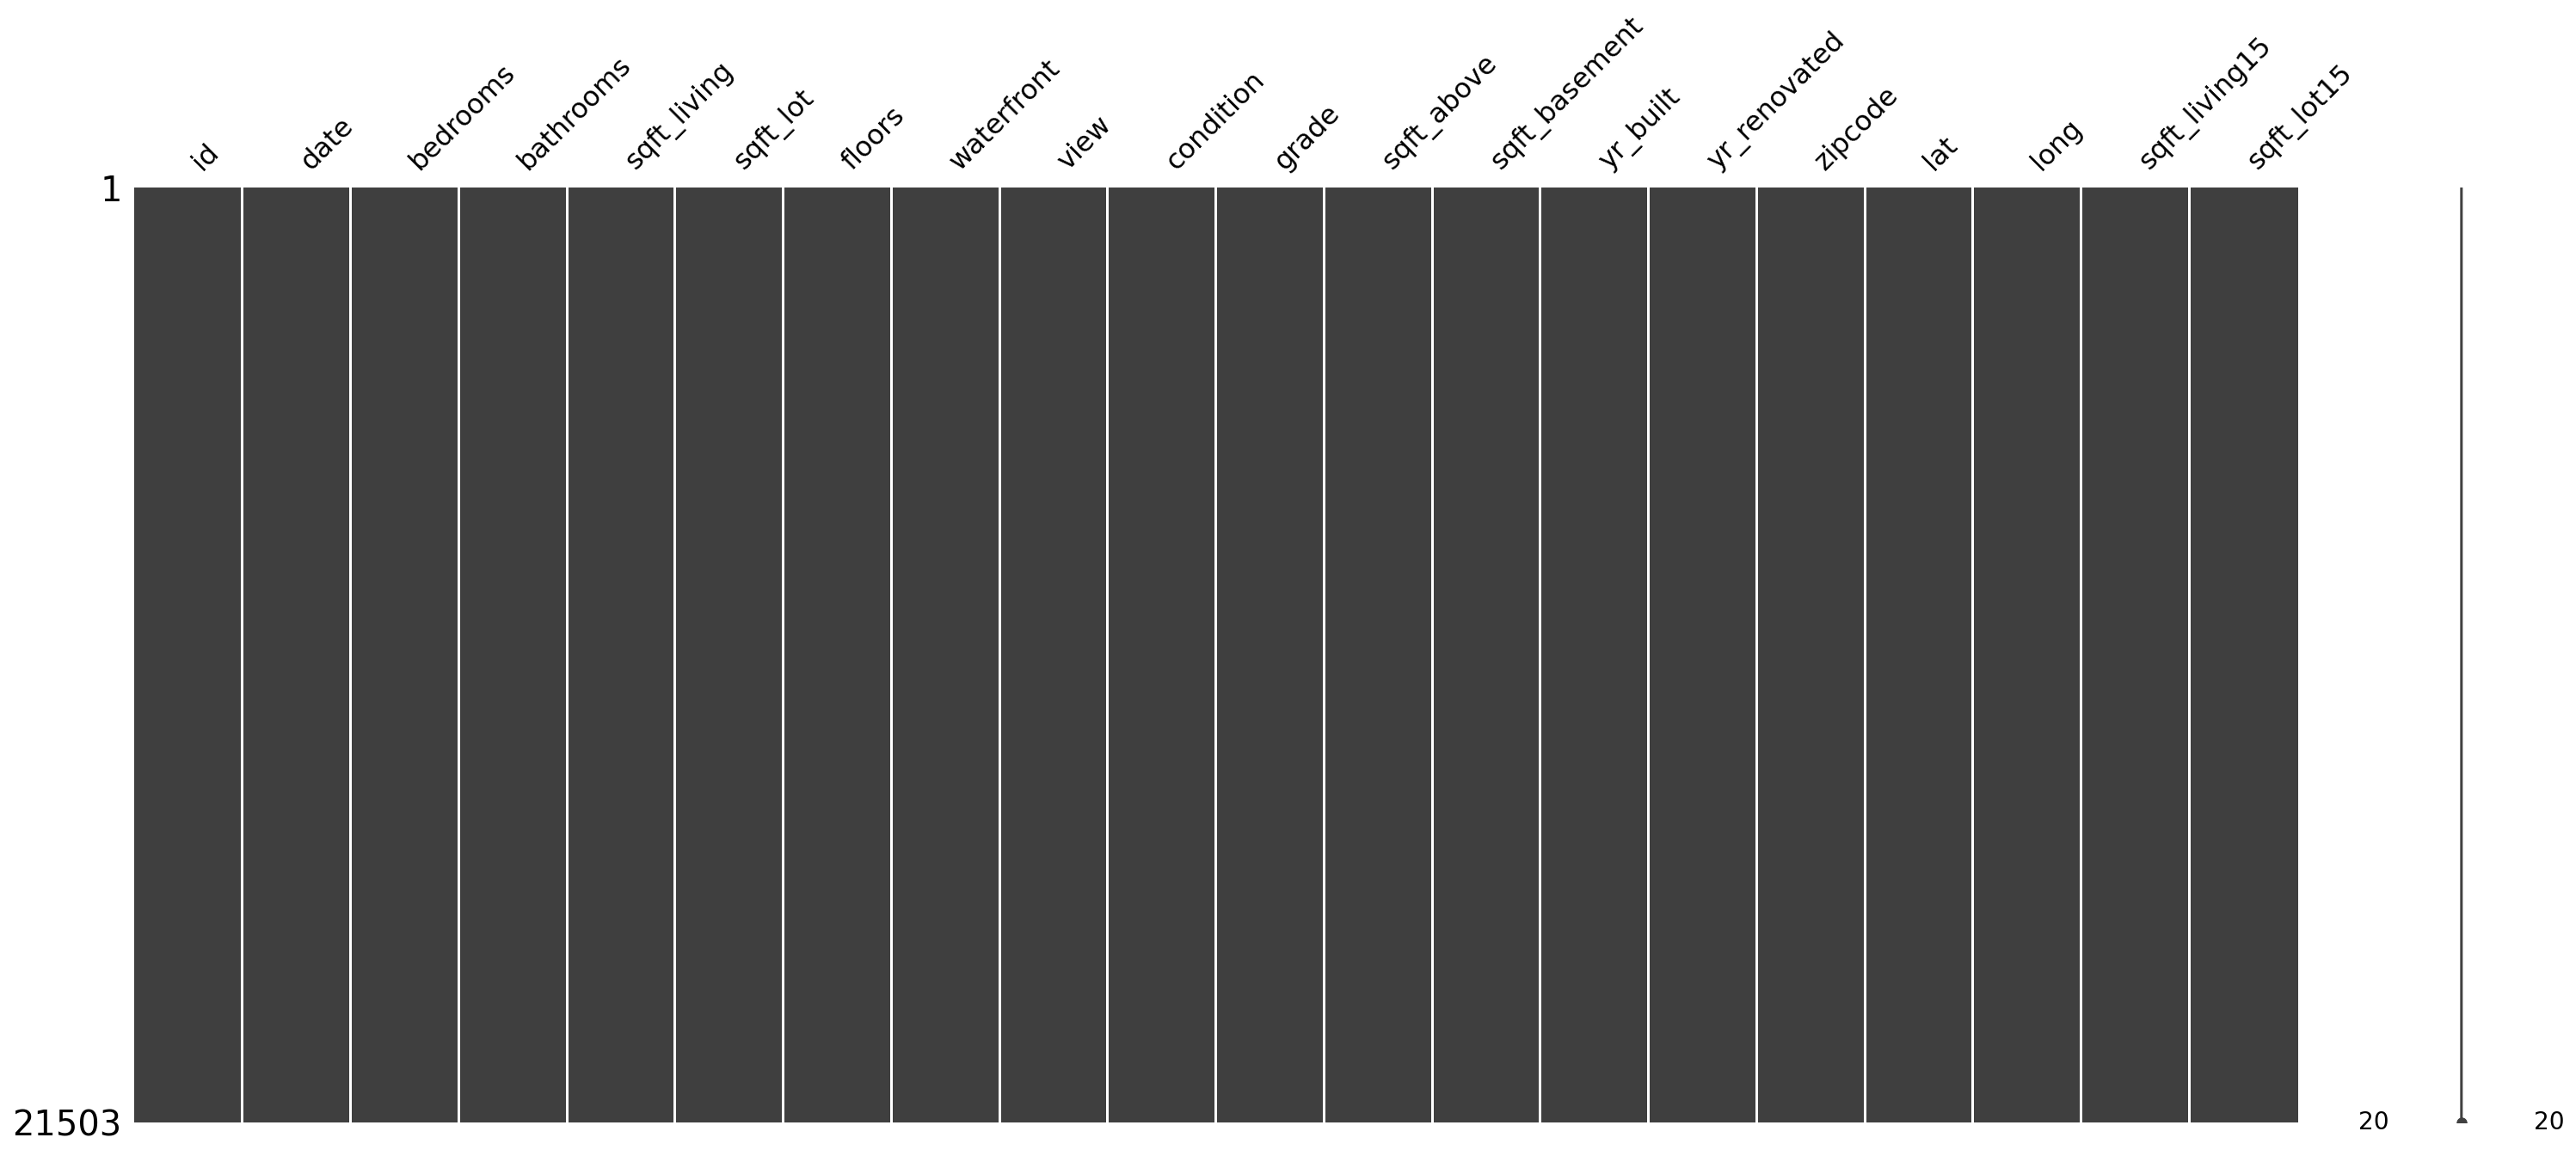

In [45]:
msno.matrix(data)

참고자료
<li><a href="https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1" target="_blank" rel="noopener noreferrer">데이터프레임 고급 인덱싱</a></li>

### 데이터 프레임 인덱싱
<ol><li><code>id</code>컬럼이 결측치인지 확인합니다.</li><li>결측치인 데이터만 뽑아냅니다.</li><li>결측치인 데이터의 개수를 셉니다.</li></ol>

In [46]:
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [47]:
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [48]:
# 3. 결측치인 데이터의 개수를 셉니다.
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [49]:
# 한 번에 뿅!
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>


In [50]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [51]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [53]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

<li><a href="https://seaborn.pydata.org/generated/seaborn.kdeplot.html" target="_blank" rel="noopener noreferrer">seaborn.kdeplot</a></li>

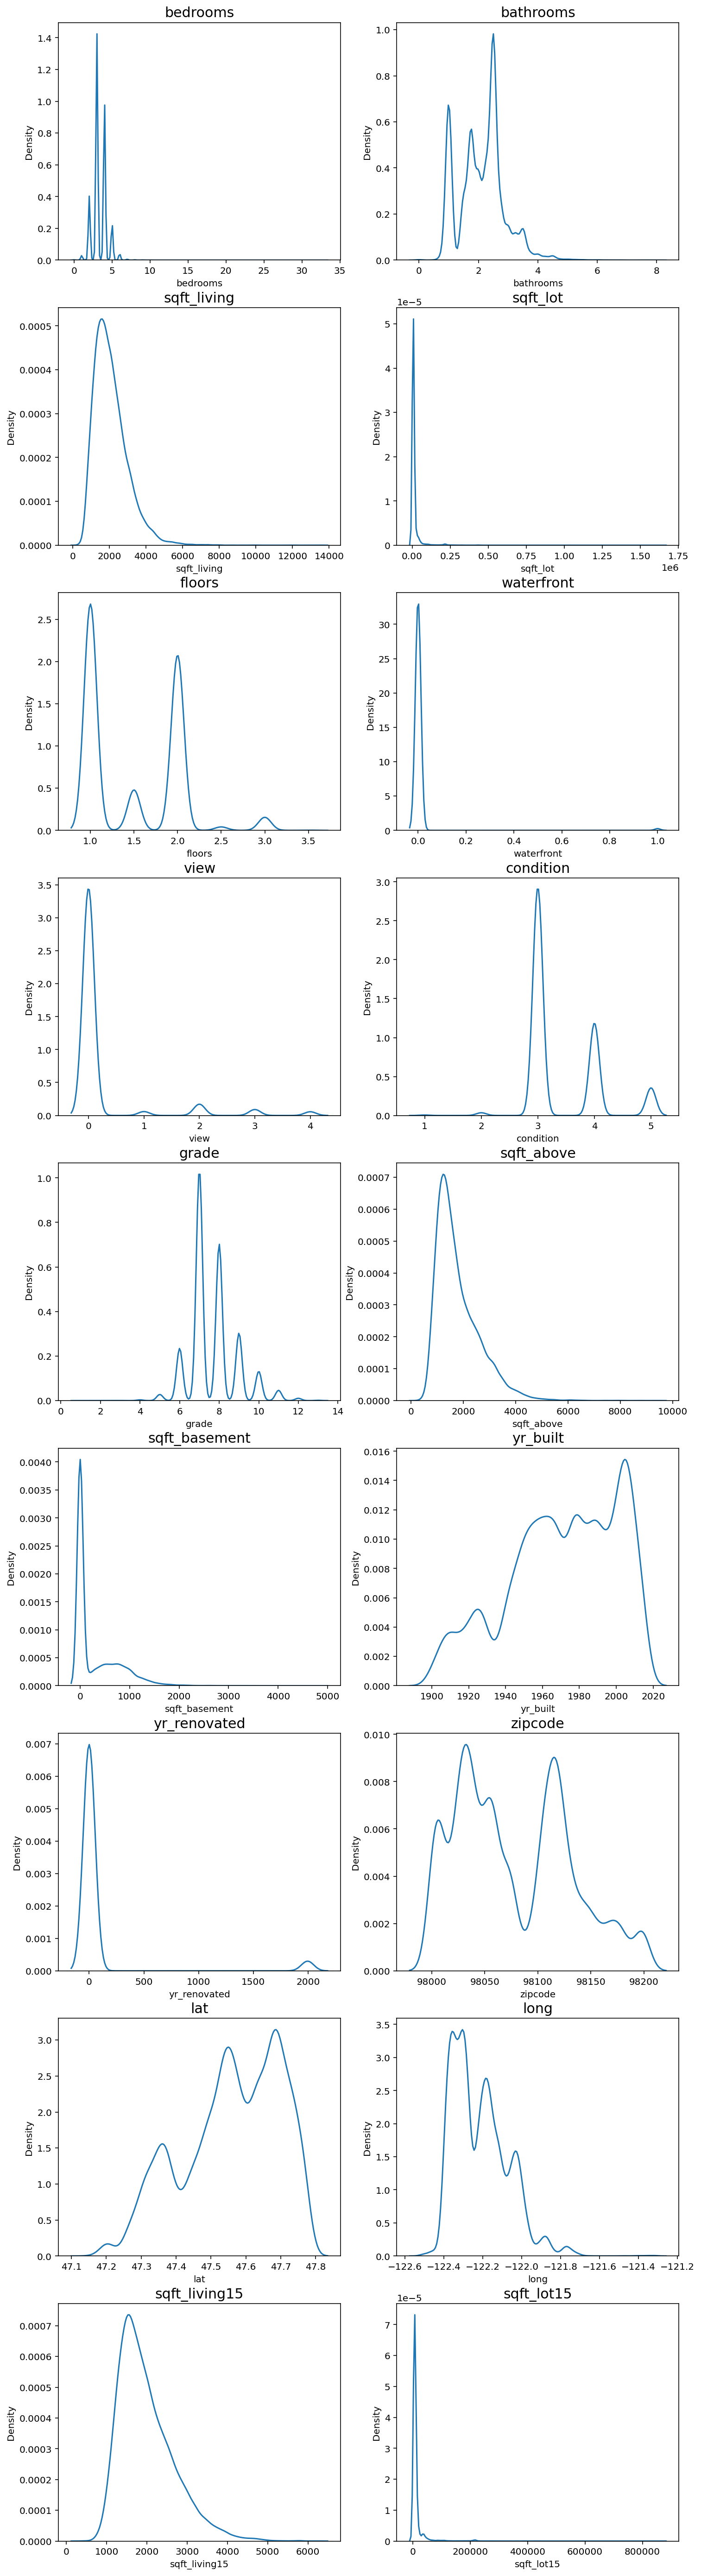

In [19]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [20]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

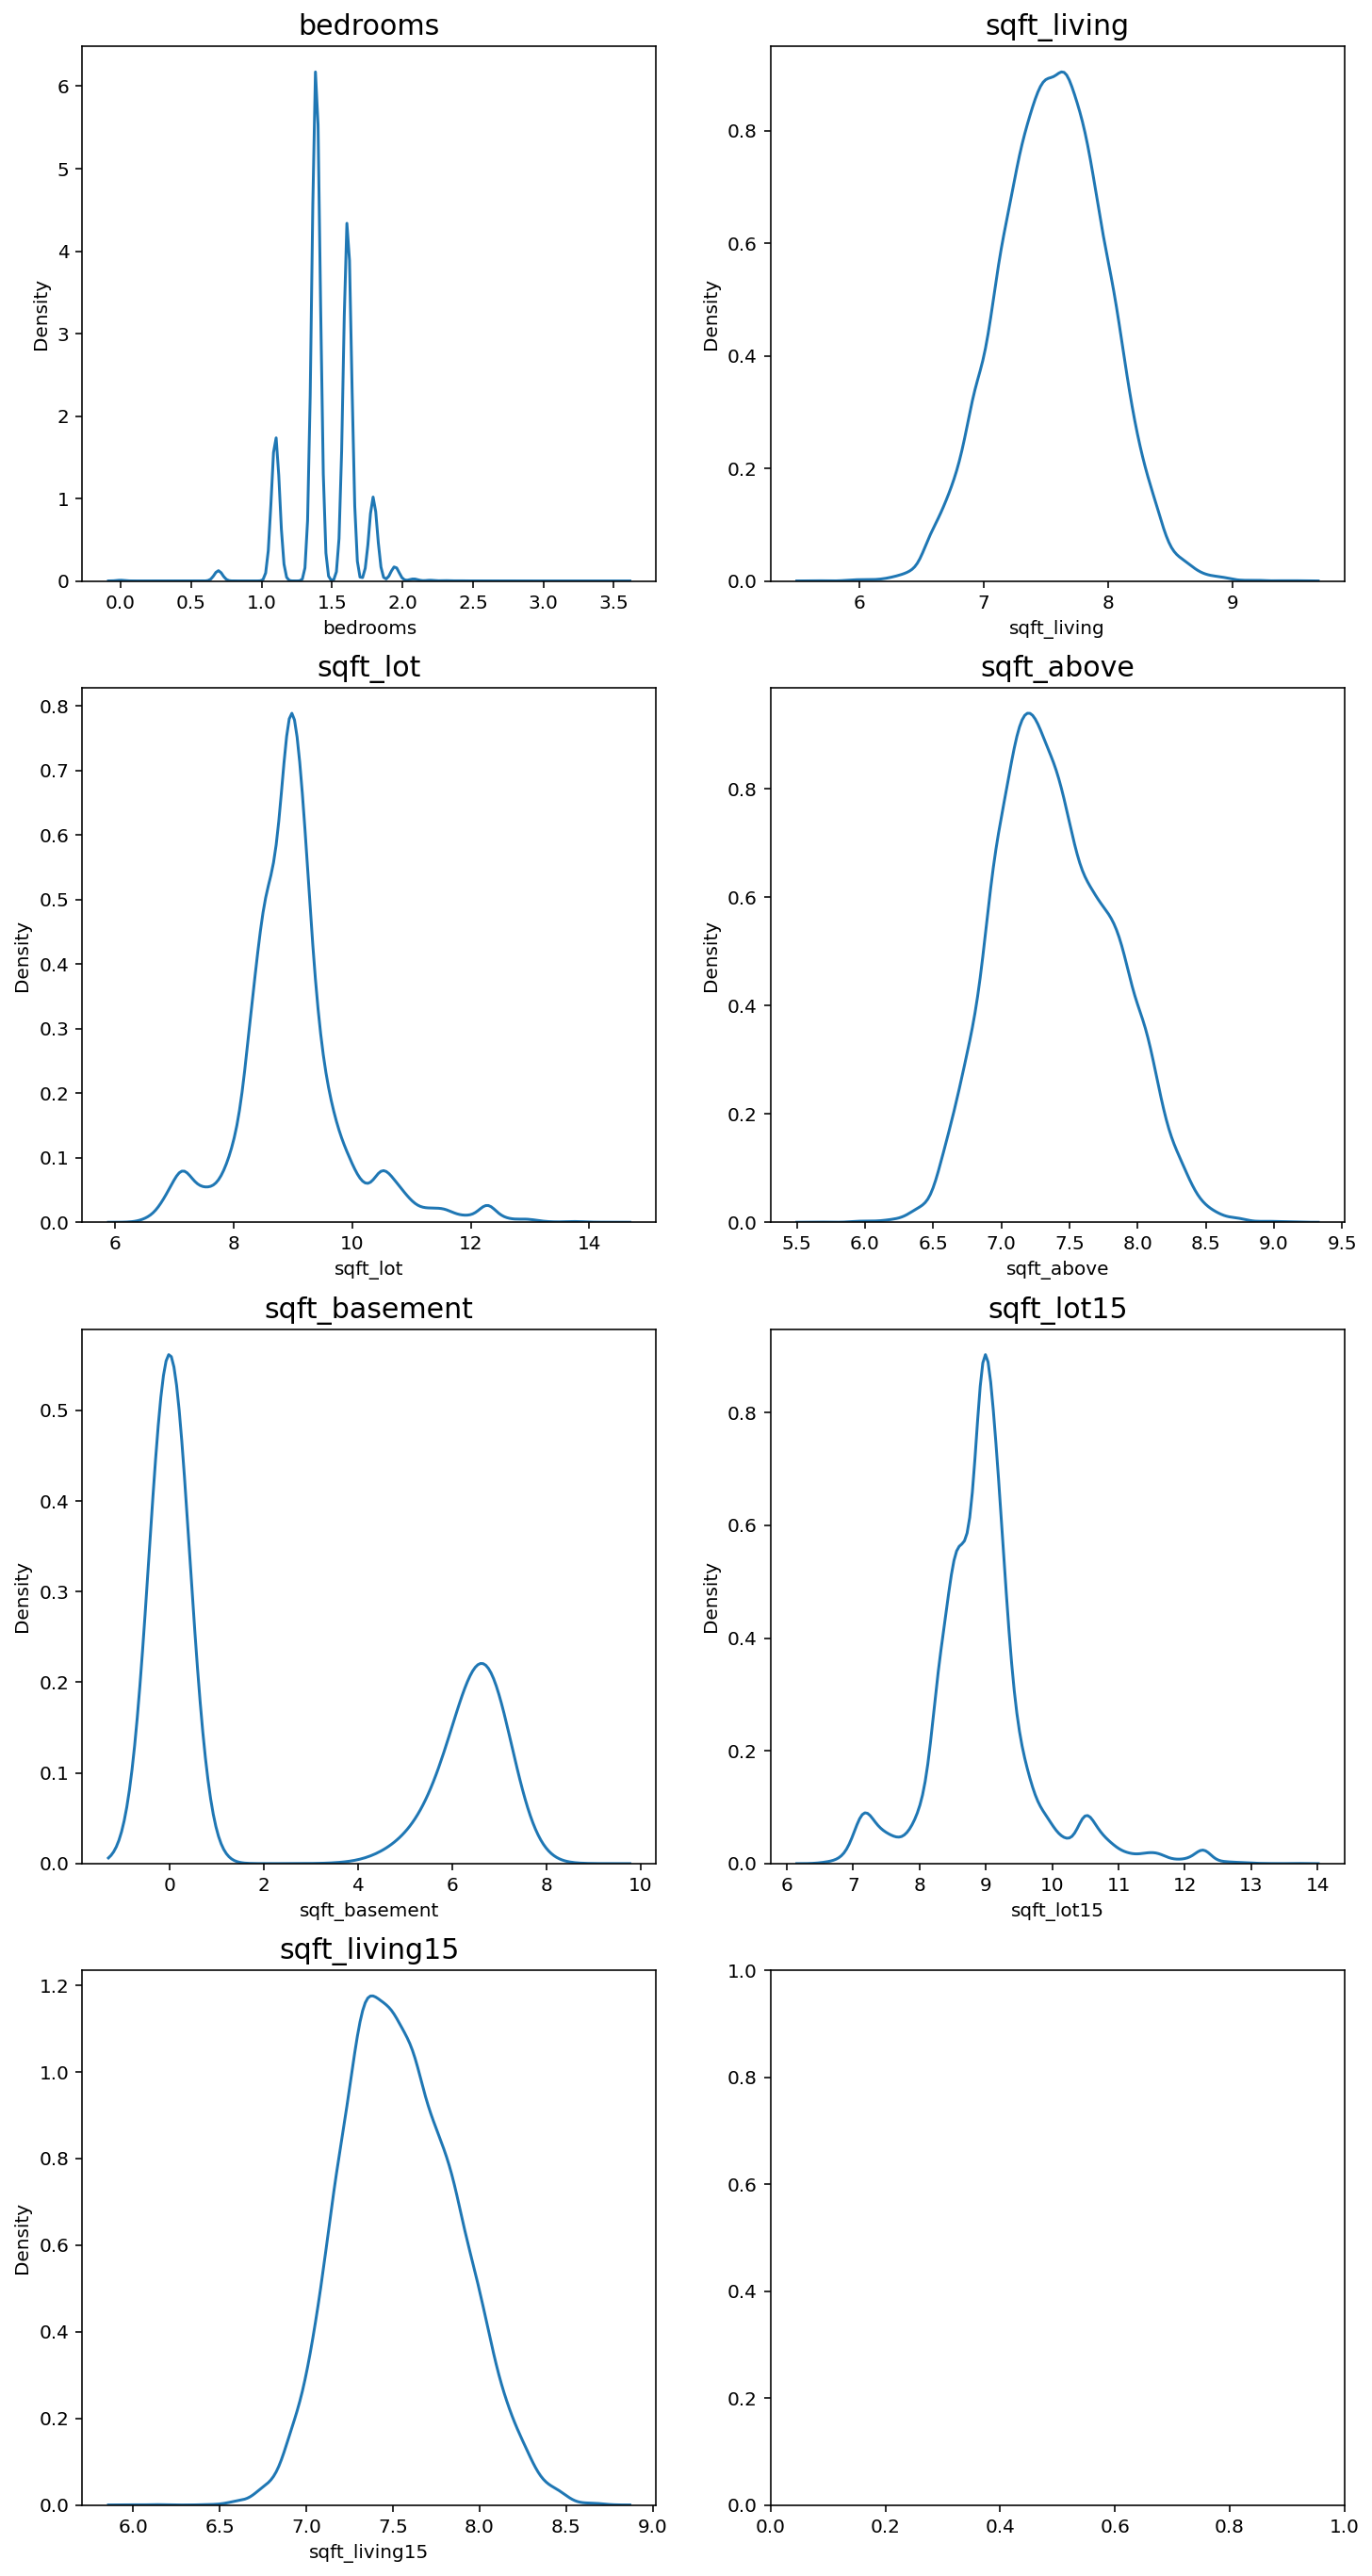

In [23]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1


어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

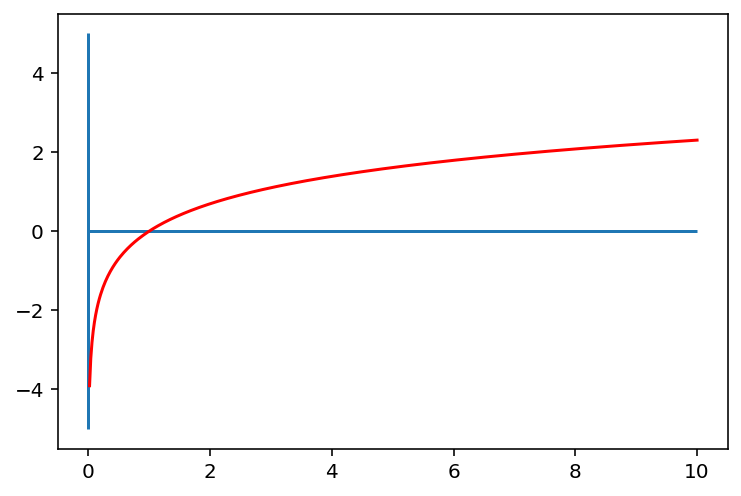

In [24]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

<ul><li><span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mn>0</mn><mo>&lt;</mo><mi>x</mi><mo>&lt;</mo><mn>1</mn></mrow><annotation encoding="application/x-tex">0 &lt; x &lt; 1</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.64444em;"></span><span class="strut bottom" style="height:0.68354em;vertical-align:-0.0391em;"></span><span class="base"><span class="mord">0</span><span class="mord rule" style="margin-right:0.2777777777777778em;"></span><span class="mrel">&lt;</span><span class="mord rule" style="margin-right:0.2777777777777778em;"></span><span class="mord mathit">x</span><span class="mord rule" style="margin-right:0.2777777777777778em;"></span><span class="mrel">&lt;</span><span class="mord rule" style="margin-right:0.2777777777777778em;"></span><span class="mord">1</span></span></span></span></span> 범위에서는 기울기가 매우 가파릅니다. 즉, <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex">x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.43056em;"></span><span class="strut bottom" style="height:0.43056em;vertical-align:0em;"></span><span class="base"><span class="mord mathit">x</span></span></span></span></span>의 구간은 <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mo>(</mo><mn>0</mn><mo separator="true">,</mo><mn>1</mn><mo>)</mo></mrow><annotation encoding="application/x-tex">(0, 1)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.75em;"></span><span class="strut bottom" style="height:1em;vertical-align:-0.25em;"></span><span class="base"><span class="mopen">(</span><span class="mord">0</span><span class="mpunct">,</span><span class="mord rule" style="margin-right:0.16666666666666666em;"></span><span class="mord">1</span><span class="mclose">)</span></span></span></span></span>로 매우 짧은 반면, <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mi>y</mi></mrow><annotation encoding="application/x-tex">y</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.43056em;"></span><span class="strut bottom" style="height:0.625em;vertical-align:-0.19444em;"></span><span class="base"><span class="mord mathit" style="margin-right:0.03588em;">y</span></span></span></span></span>의 구간은 <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mo>(</mo><mo>−</mo><mi mathvariant="normal">∞</mi><mo separator="true">,</mo><mn>0</mn><mo>)</mo></mrow><annotation encoding="application/x-tex">(-\infty, 0)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.75em;"></span><span class="strut bottom" style="height:1em;vertical-align:-0.25em;"></span><span class="base"><span class="mopen">(</span><span class="mord">−</span><span class="mord">∞</span><span class="mpunct">,</span><span class="mord rule" style="margin-right:0.16666666666666666em;"></span><span class="mord">0</span><span class="mclose">)</span></span></span></span></span>으로 매우 큽니다.</li><li>따라서 0에 가깝게 모여있는 값들이 <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex">x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.43056em;"></span><span class="strut bottom" style="height:0.43056em;vertical-align:0em;"></span><span class="base"><span class="mord mathit">x</span></span></span></span></span>로 입력되면, 그 함수값인 <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mi>y</mi></mrow><annotation encoding="application/x-tex">y</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.43056em;"></span><span class="strut bottom" style="height:0.625em;vertical-align:-0.19444em;"></span><span class="base"><span class="mord mathit" style="margin-right:0.03588em;">y</span></span></span></span></span> 값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.</li><li>반면, <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex">x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.43056em;"></span><span class="strut bottom" style="height:0.43056em;vertical-align:0em;"></span><span class="base"><span class="mord mathit">x</span></span></span></span></span>값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 이는 곧 큰 <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex">x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.43056em;"></span><span class="strut bottom" style="height:0.43056em;vertical-align:0em;"></span><span class="base"><span class="mord mathit">x</span></span></span></span></span>값들에 대해서는 <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mi>y</mi></mrow><annotation encoding="application/x-tex">y</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.43056em;"></span><span class="strut bottom" style="height:0.625em;vertical-align:-0.19444em;"></span><span class="base"><span class="mord mathit" style="margin-right:0.03588em;">y</span></span></span></span></span>값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex">x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.43056em;"></span><span class="strut bottom" style="height:0.43056em;vertical-align:0em;"></span><span class="base"><span class="mord mathit">x</span></span></span></span></span>를 비교적 작은 <span><span class="katex"><span class="katex-mathml"><math><semantics><mrow><mi>y</mi></mrow><annotation encoding="application/x-tex">y</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="strut" style="height:0.43056em;"></span><span class="strut bottom" style="height:0.625em;vertical-align:-0.19444em;"></span><span class="base"><span class="mord mathit" style="margin-right:0.03588em;">y</span></span></span></span></span>값의 구간 내에 모이게 하는 특징을 가집니다. </li></ul>

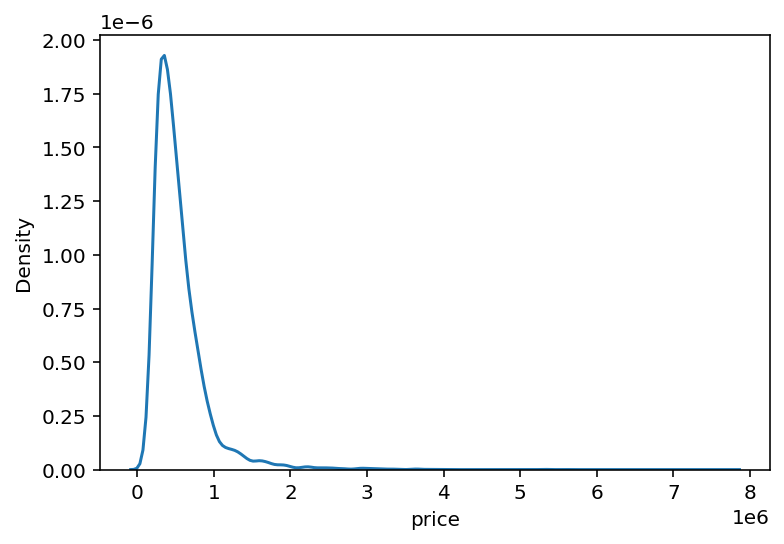

In [25]:
sns.kdeplot(y)
plt.show()

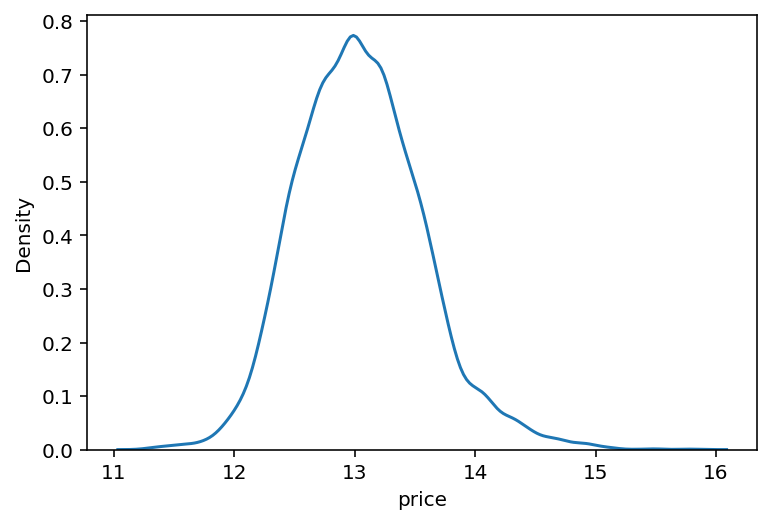

In [27]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [28]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

<li><a href="https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4." target="_blank" rel="noopener noreferrer">Part 1. Introduction to Ensemble Learning</a></li>
<li><a href="https://jamm-notnull.tistory.com/16" target="_blank" rel="noopener noreferrer">Kaggle Ensemble Guide</a></li>

In [29]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [55]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))
        
        

In [56]:
get_cv_score(models)

NameError: name 'x' is not defined

<p><a href="https://ltlkodae.tistory.com/19" target="_blank" rel="noopener noreferrer">결정계수 R squared</a>  </p>

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [34]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [36]:
y_pred = AveragingBlending(models, x, y, sub)
y_pred

array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [37]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [38]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [39]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


# 2. 랭킹을 올리기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) 
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
y = train['price']
del train['price']

print(train.columns)
print(len(train.columns))

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
20


In [6]:
del train['id']

print(train.columns)
print(len(train.columns))

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
19


In [7]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)
print(len(test.columns))

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
19


In [8]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

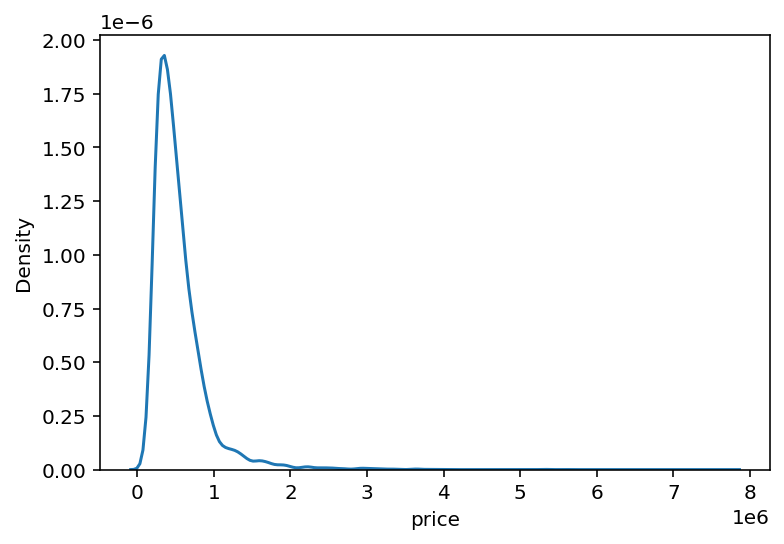

In [9]:
sns.kdeplot(y)
plt.show()

<ul><li><a href="https://numpy.org/doc/stable/reference/generated/numpy.log1p.html" target="_blank" rel="noopener noreferrer">numpy.log1p</a></li><li><a href="https://numpy.org/doc/stable/reference/generated/numpy.expm1.html" target="_blank" rel="noopener noreferrer">numpy.expm1</a></li></ul>

In [10]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

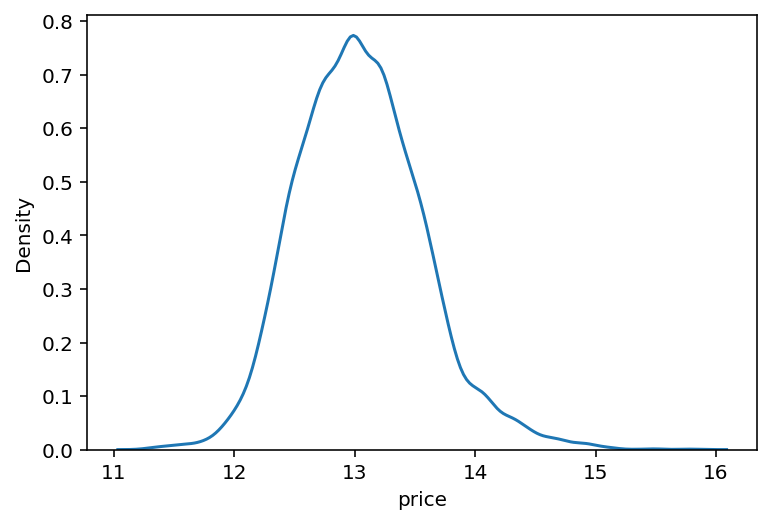

In [11]:
sns.kdeplot(y)
plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### RMSE 계산

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.sqrt  
https://www.delftstack.com/ko/api/numpy/python-numpy-sqrt/

In [14]:
# np.sqrt(arr, out=None)
# out이 주어지면 결과는out에 저장됩니다. out은arr와 같은 모양이어야합니다.
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [15]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

### GradientBoostingRegressor  
참고자료 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

### XGBRegressor
참고자료 : https://joyfuls.tistory.com/63

### LGBMRegressor
참고자료: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

### RandomForestRegressor
참고자료: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [16]:
random_state=42

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost,xgboost,lightgbm, rdforest]


In [17]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [ ]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

In [ ]:
def get_scores(models, train, y):
    dic = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        dic[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(dic, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

get_scores(models, train, y)

# 하이퍼 파라미터 튜닝(그리드 탐색)

In [ ]:
from sklearn.model_selection import GridSearchCV

GridSearchCV에 입력되는 인자들
<ul><li><code>param_grid</code> : 탐색할 파라미터의 종류 (딕셔너리로 입력)</li><li><code>scoring</code> : 모델의 성능을 평가할 지표</li><li><code>cv</code> : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수</li><li><code>verbose</code> : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)</li><li><code>n_jobs</code> : 그리드 탐색을 진행하면서 사용할 CPU의 개수</li></ul>

<code>param_grid</code>에 탐색할 xgboost 관련 하이퍼 파라미터

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

모델은 LightGBM(lgbm)

In [ ]:
model = LGBMRegressor(random_state=random_state)

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

In [ ]:
grid_model.cv_results_

In [ ]:
params = grid_model.cv_results_['params']
params

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

In [ ]:
results = pd.DataFrame(params)
results['score'] = score
results

<li><a href="https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter" target="_blank" rel="noopener noreferrer">사이킷런 - The scoring parameter: defining model evaluation rules</a></li>

In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

In [ ]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

<li><a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html" target="_blank" rel="noopener noreferrer">pandas.DataFrame.sort_values</a></li>

In [ ]:
results.sort_values('RMSLE')

In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    grid_model = GridSearchCV(model, param_grid = param_grid, scoring='neg_mean_squared_error', n_jobs=n_jobs, cv=5, verbose=verbose)
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

In [ ]:
prediction = np.expm1(prediction)
prediction

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
submission['price'] = prediction
submission.head()

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

In [ ]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""
def save_submission(model, train, y, test, model_name, rmsle):
    # 모델학습 및 예측
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    # 결과 데이터 가져오기
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # 결과 저장
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [108]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


<ul><li><a href="http://machinelearningkorea.com/2019/09/29/lightgbm-파라미터/" target="_blank" rel="noopener noreferrer">lightGBM / XGBoost 파라미터 설명</a></li><li><a href="https://injo.tistory.com/48" target="_blank" rel="noopener noreferrer">Chapter 4. 분류 - LightGBM</a>    </li></ul>

# 3. 직접 튜닝해 보기

## 1. 라이브러리
## 2. 데이터 준비하기
## 3. 사용할 함수
## 4. 모델별 점수
## 5. LGBMRegressor
## 6. XGBRegressor
## 7. GradientBoostingRegressor
## 8. RandomForestRegressor
## 9. Blending

## 1. 라이브러리

In [86]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2. 데이터 준비하기

In [87]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) 

y = train['price']
del train['price']

del train['id']

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']



## 결측치 확인

<AxesSubplot:>

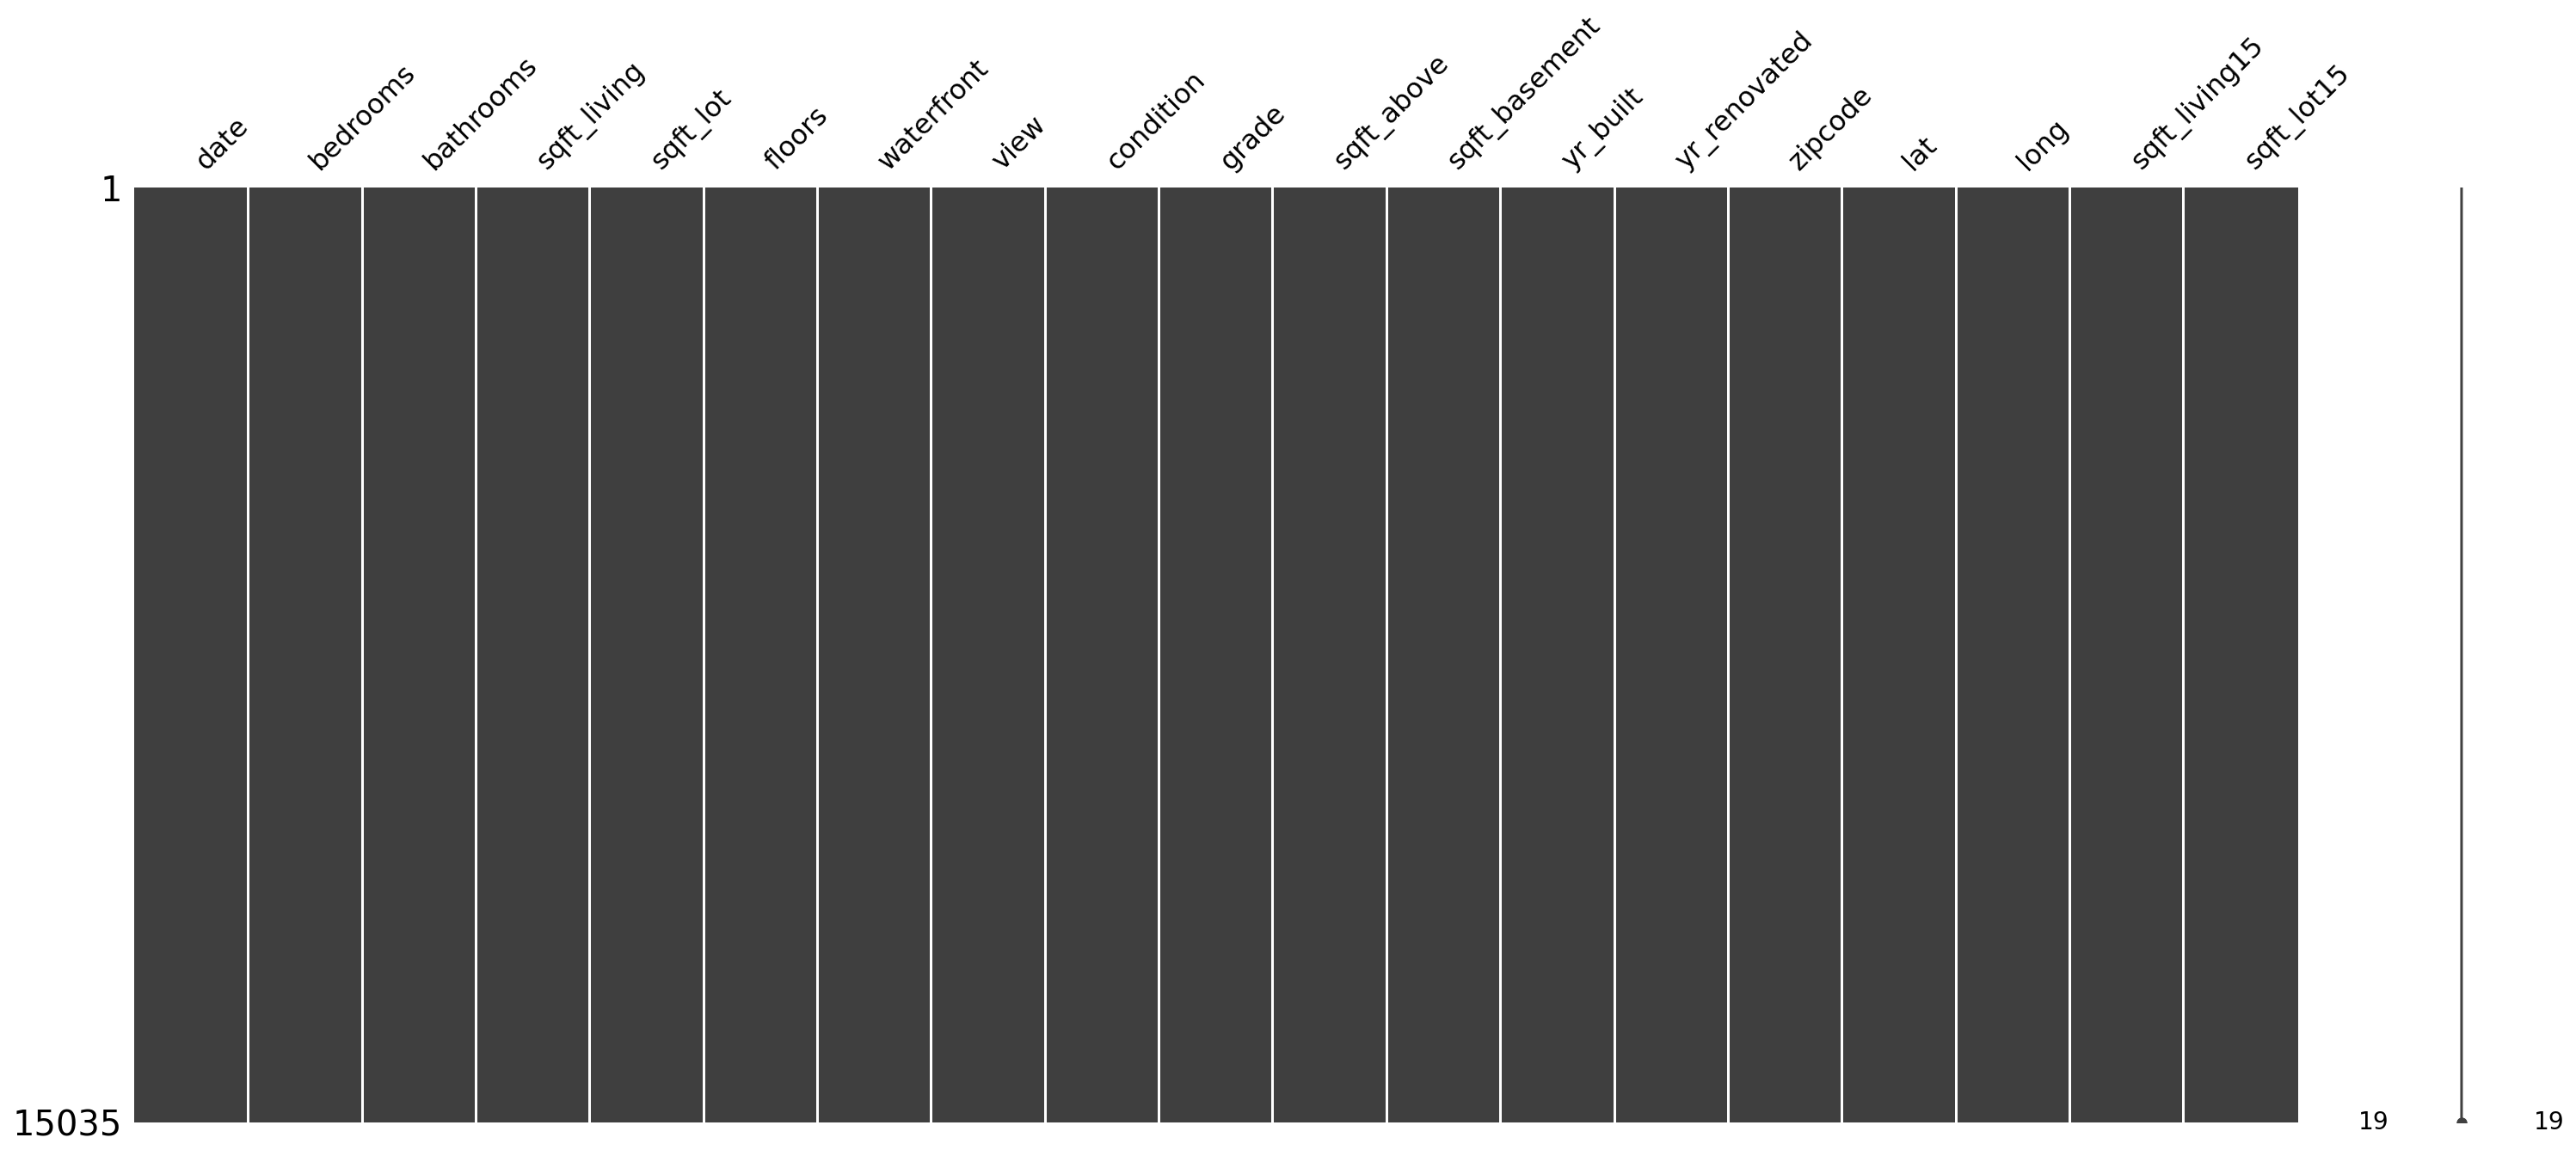

In [88]:
msno.matrix(train)

<AxesSubplot:>

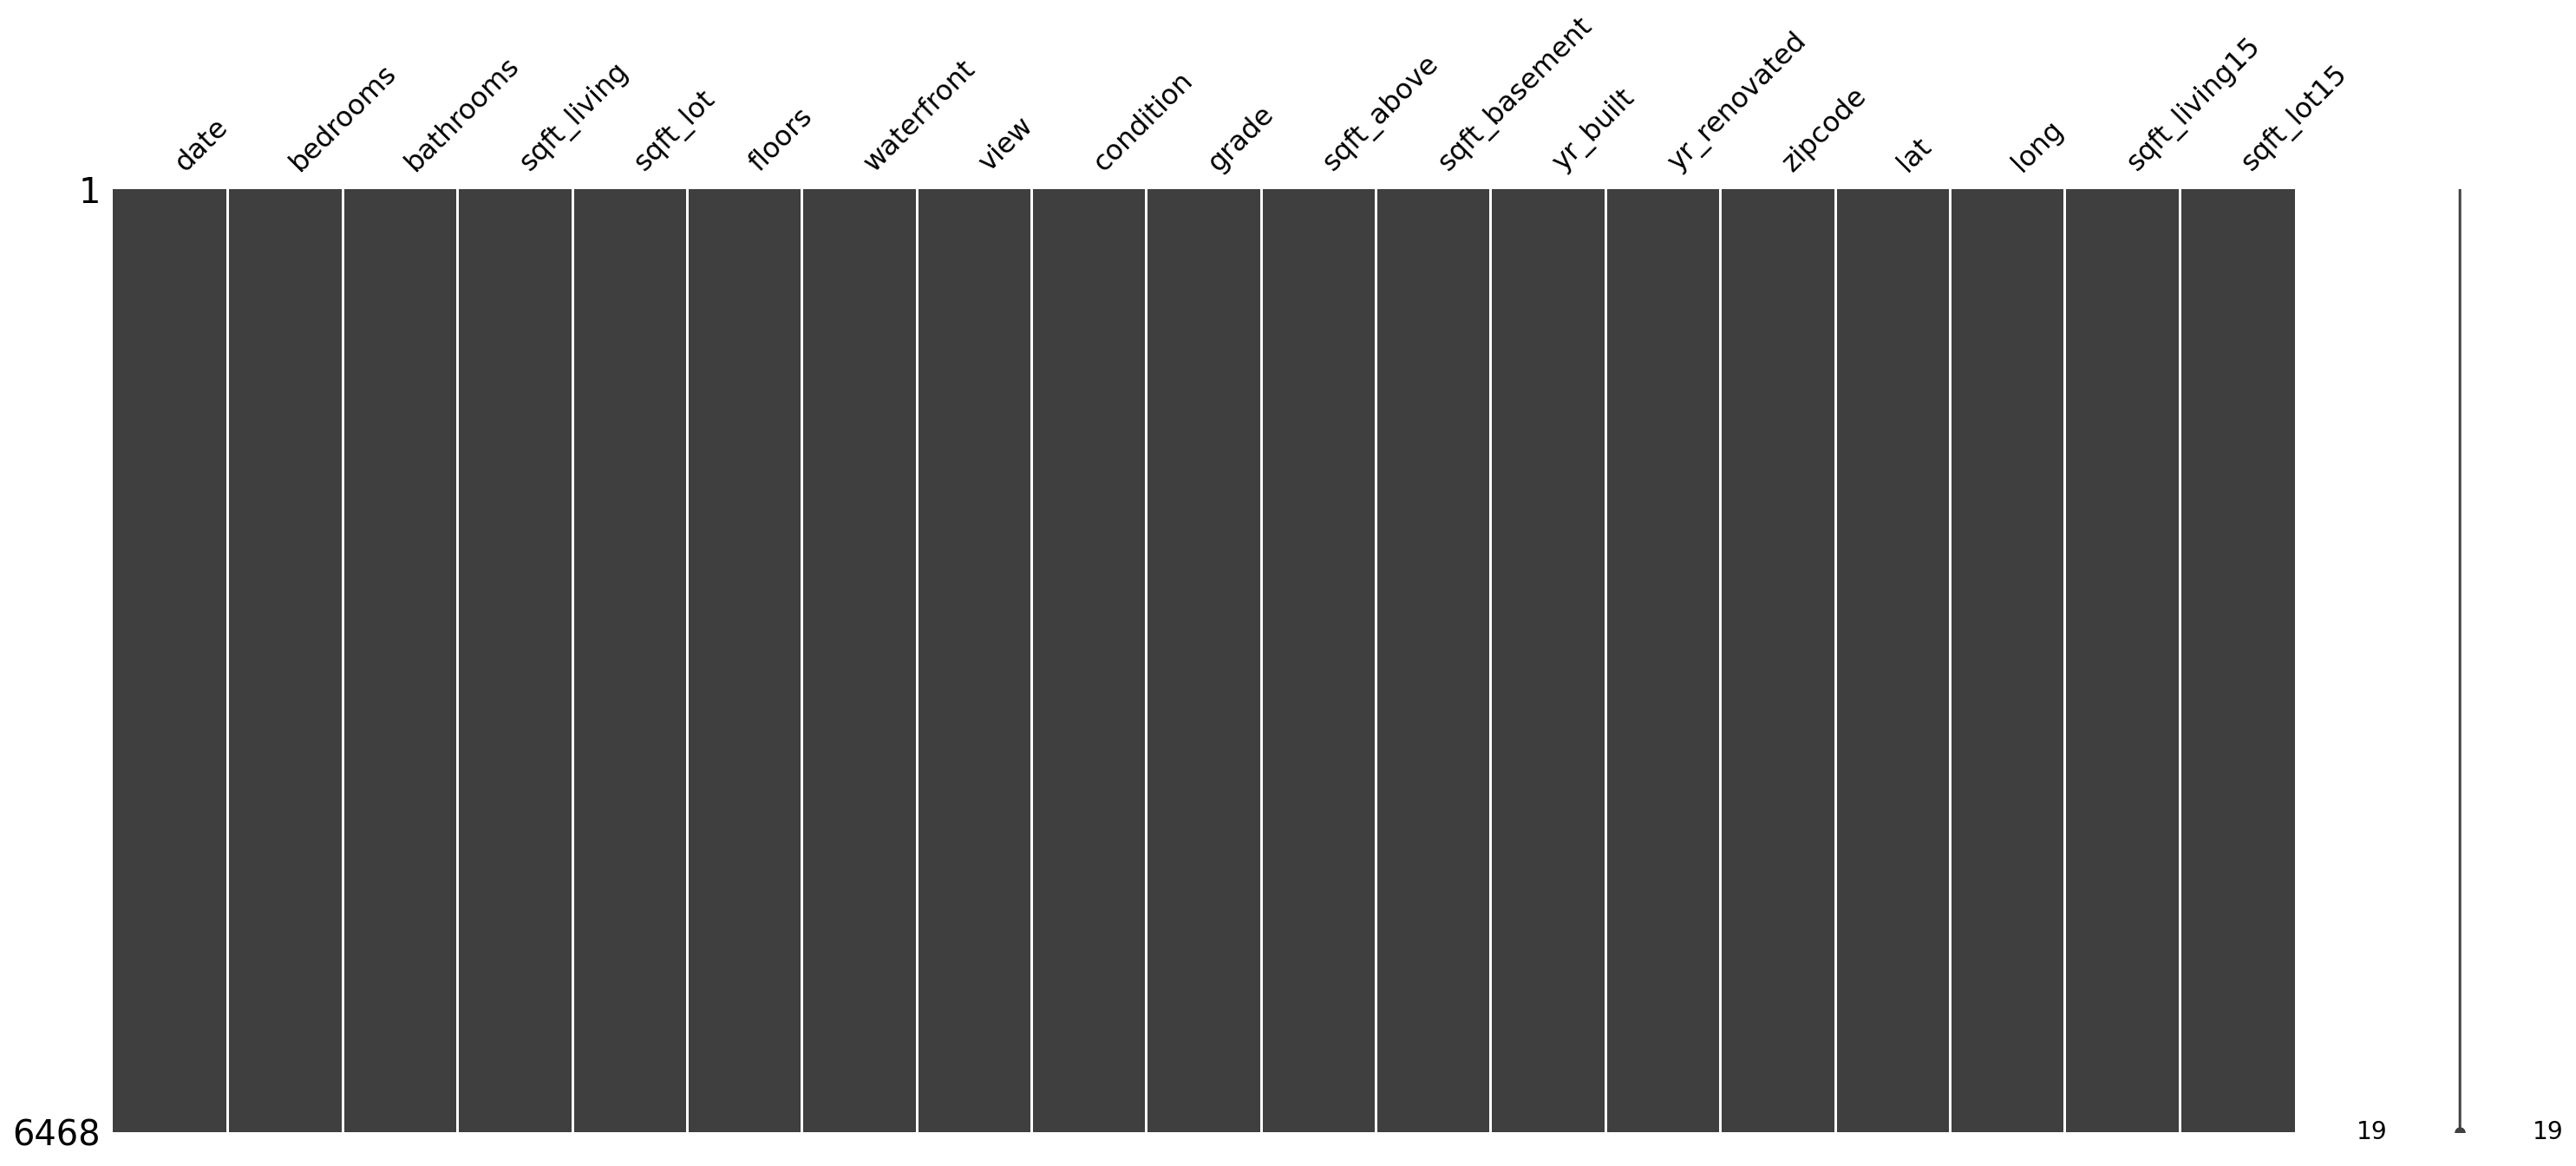

In [89]:
msno.matrix(test)

In [90]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


## 데이터 분포 확인

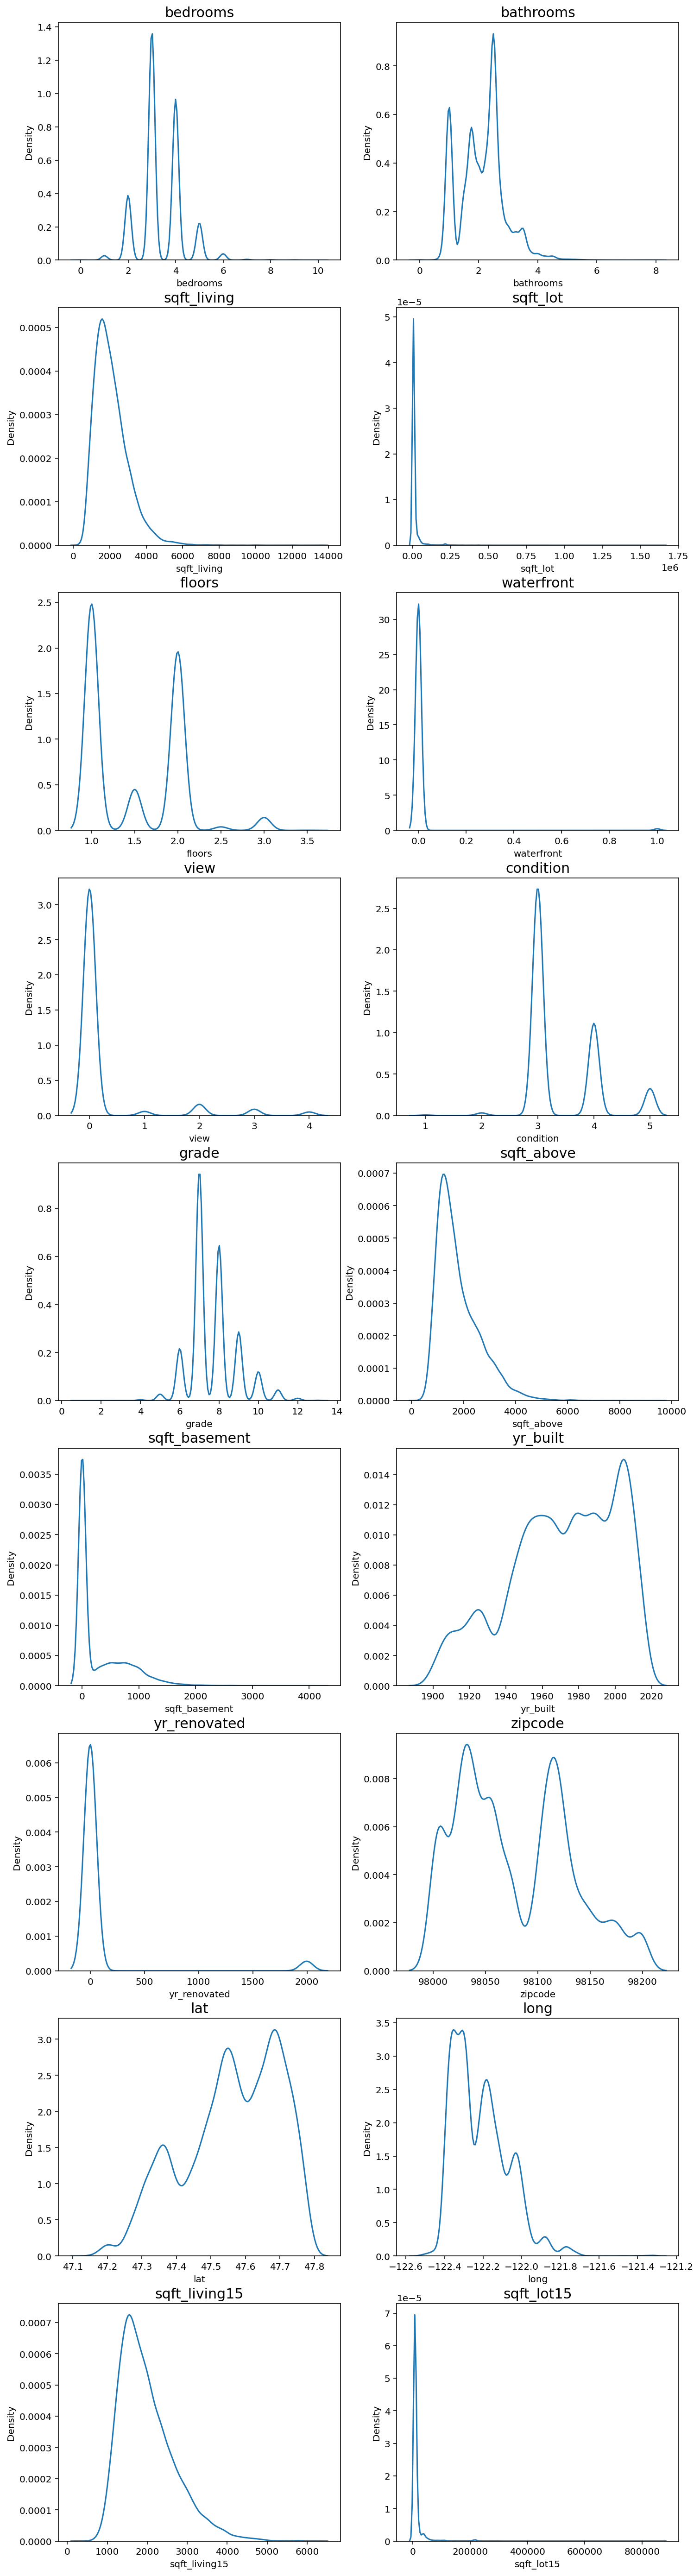

In [91]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [92]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

In [93]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    test[c] = np.log1p(test[c].values)

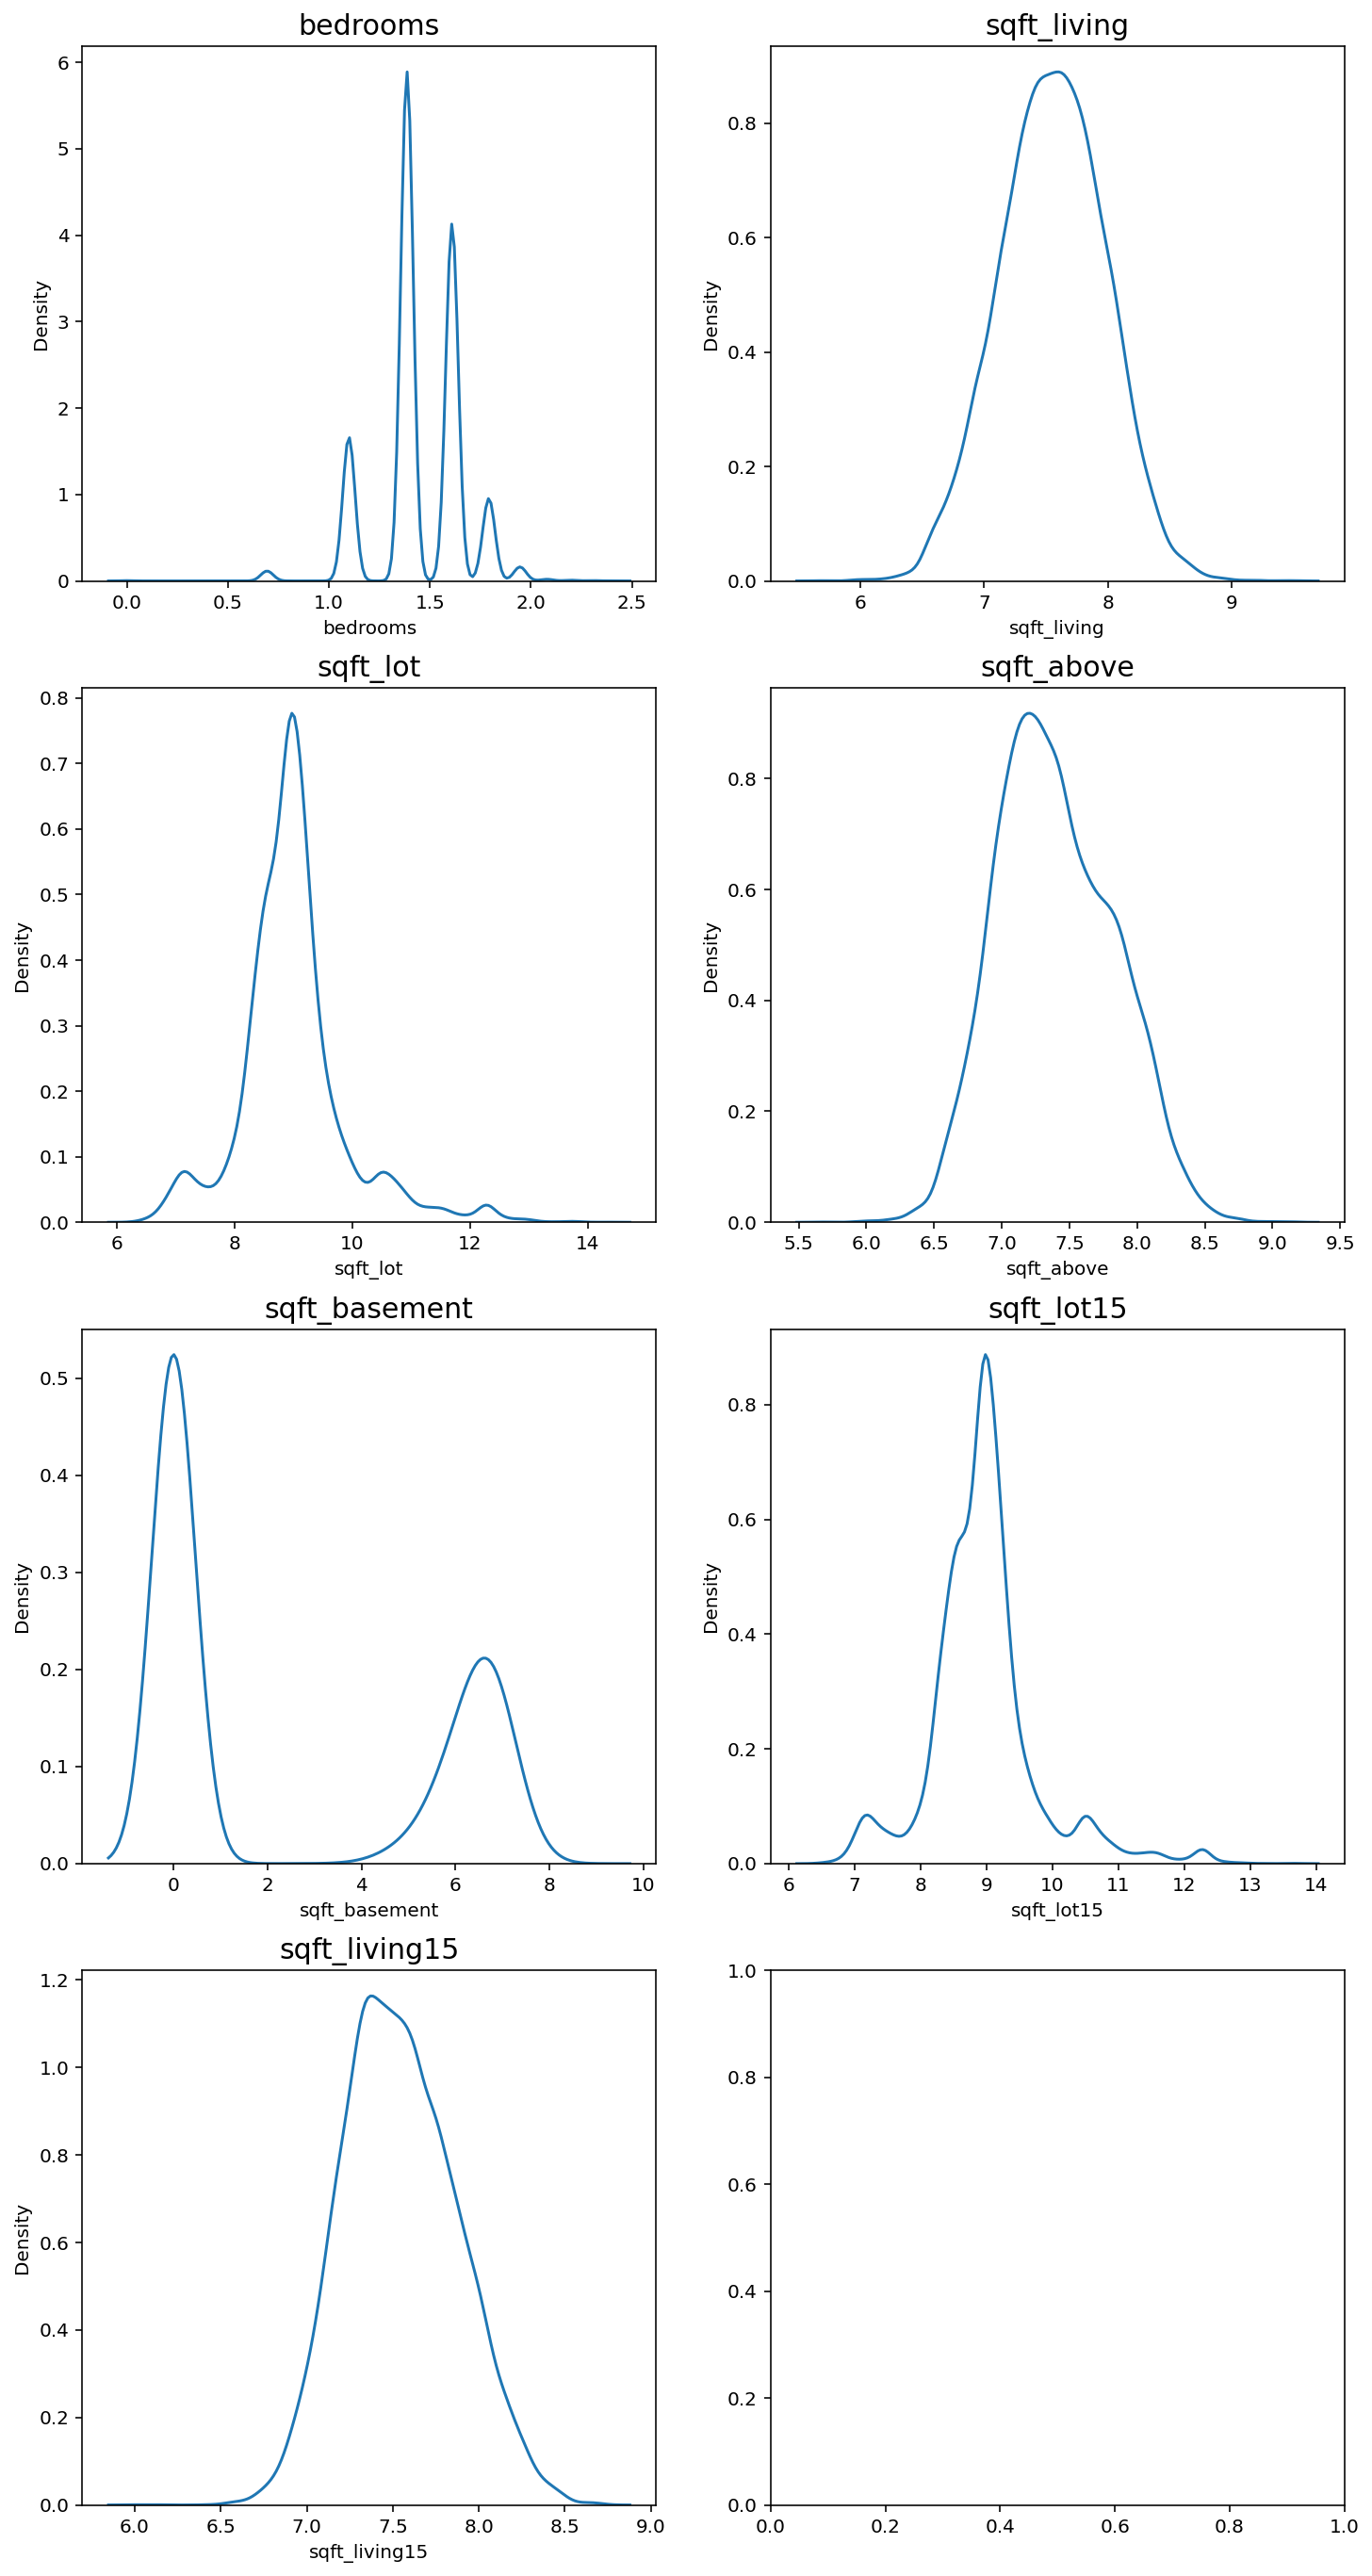

In [94]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

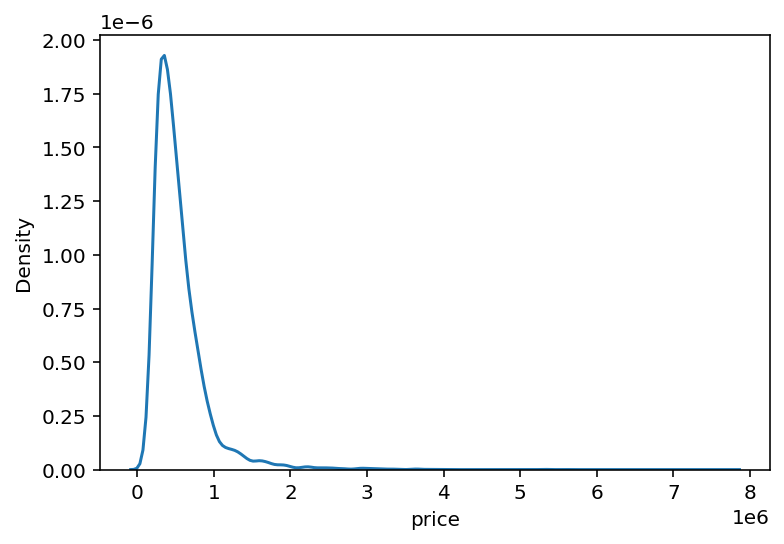

In [95]:
sns.kdeplot(y)
plt.show()

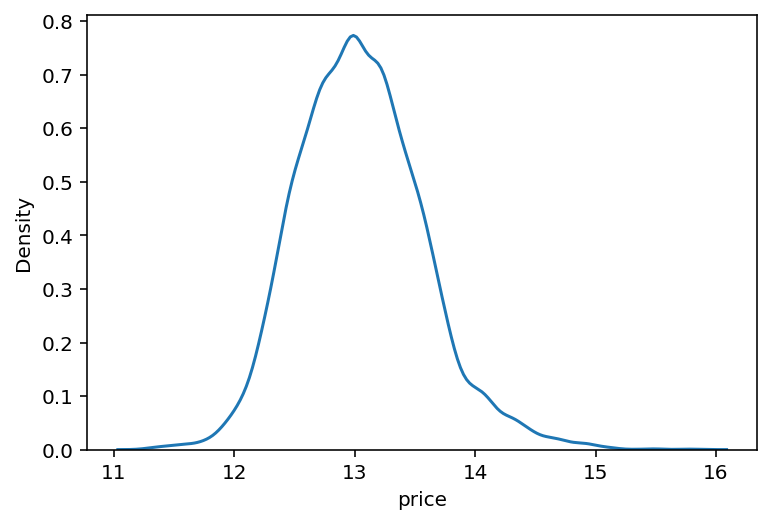

In [96]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

## 3. 사용할 함수

In [97]:
# RMSE 계산
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def get_scores(models, train, y):
    dic = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        dic[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(dic, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

# 그리드 탐색
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    grid_model = GridSearchCV(model, param_grid = param_grid, scoring='neg_mean_squared_error', n_jobs=n_jobs, cv=5, verbose=verbose)
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results


def save_submission(model, train, y, test, model_name, rmsle):
    # 모델학습 및 예측
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    # 결과 데이터 가져오기
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # 결과 저장
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

## 4. 모델별 점수

In [98]:
random_state=42

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
adaboost = AdaBoostRegressor(random_state=random_state) # 모델 하나더 추가, 이상치에 민감한 모델

models = [gboost, xgboost, lightgbm, rdforest, adaboost]

get_scores(models, train, y)

,RMSE
AdaBoostRegressor,191259.885689
RandomForestRegressor,140949.730605
GradientBoostingRegressor,134139.377568
XGBRegressor,126741.713379
LGBMRegressor,123074.604066


## 5. LGBMRegressor

In [99]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate' : [0.1, 0.05, 0.01],
    'max_depth' : [-1, 10, 50],
    'feature_fraction' : [0.7, 0.9, 1],
    'boosting' : ['gbdt', 'dart'],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV] END boosting=gbdt, feature_fraction=0.7, learning_rate=0.1, max_depth=-1, n_estimators=50; total time=   0.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV] END boosting=gbdt, feature_fraction=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100; total time=   0.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV] END b

,boosting,feature_fraction,learning_rate,max_depth,n_estimators,score,RMSLE
2,gbdt,0.7,0.10,-1,150,-0.026065,0.161446
8,gbdt,0.7,0.10,50,150,-0.026065,0.161446
29,gbdt,0.9,0.10,-1,150,-0.026229,0.161954
35,gbdt,0.9,0.10,50,150,-0.026229,0.161954
5,gbdt,0.7,0.10,10,150,-0.026257,0.162039
...,...,...,...,...,...,...,...
128,dart,0.9,0.01,-1,150,-40.314555,6.349374
134,dart,0.9,0.01,50,150,-40.314555,6.349374
104,dart,0.7,0.01,10,150,-40.317054,6.349571
101,dart,0.7,0.01,-1,150,-40.317070,6.349572


In [100]:
# private Score 가장 낮은 점
model = LGBMRegressor(boosting = 'gbdt', colsample_bytree = 0.7, learning_rate = 0.1, max_depth = -1, n_estimators = 50, num_iterations=1000, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', rmsle='0.1612')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1612.csv saved!


## 6. XGBRegressor

In [101]:
param_grid = {
    'eta' : [0.01, 0.05, 0.1],
    'booster' : ['gbtree', 'dart'],
    'max_depth' : [10, 50],
    'colsample_bytree' : [0.7, 0.9]
}
model = XGBRegressor(seed=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=10; total time=   0.6s
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=10; total time=   0.6s
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=10; total time=   0.6s
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=10; total time=   0.6s
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=10; total time=   0.6s
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=50; total time=   0.6s
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=50; total time=   0.6s
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=50; total time=   0.5s
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=50; total time=   0.6s
[CV] END booster=gbtree, colsample_bytree=0.7, eta=0.01, max_depth=50; total time=   0.6s
[CV] END booster=gbtree, colsample_byt

,booster,colsample_bytree,eta,max_depth,score,RMSLE
16,dart,0.7,0.10,10,-0.026209,0.161893
22,dart,0.9,0.10,10,-0.026663,0.163287
10,gbtree,0.9,0.10,10,-0.026830,0.163799
4,gbtree,0.7,0.10,10,-0.026888,0.163975
17,dart,0.7,0.10,50,-0.027372,0.165446
23,dart,0.9,0.10,50,-0.027682,0.166378
5,gbtree,0.7,0.10,50,-0.027984,0.167283
11,gbtree,0.9,0.10,50,-0.028171,0.167842
14,dart,0.7,0.05,10,-0.034411,0.185501
20,dart,0.9,0.05,10,-0.034825,0.186613


In [102]:
# private 점수가 가장 낮은 모델
model = XGBRegressor(booster='dart', colsample_bytree=0.7, eta=0.1, max_depth = 50, seed=random_state)
save_submission(model, train, y, test, 'xgbr', rmsle='0.1630')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgbr_RMSLE_0.1630.csv saved!


## 7. GradientBoostingRegressor

In [103]:
param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators' : [50, 100, 150],
    'max_depth' : [3, 10, 50]
}
model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=5, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
14,0.05,10,150,-0.029307,0.171194
23,0.10,10,150,-0.029394,0.171448
22,0.10,10,100,-0.029449,0.171607
13,0.05,10,100,-0.029707,0.172359
21,0.10,10,50,-0.029891,0.172890
20,0.10,3,150,-0.031162,0.176528
12,0.05,10,50,-0.033122,0.181994
19,0.10,3,100,-0.033388,0.182724
11,0.05,3,150,-0.035374,0.188079
10,0.05,3,100,-0.039725,0.199312


GradientBoostingRegressor 그리드 서치가 너무 오래 걸려서 감으로 파라미터를 설정 

In [104]:
gboost = GradientBoostingRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 100, random_state=random_state)
save_submission(gboost, train, y, test, 'gboost', rmsle='0.1712')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_gboost_RMSLE_0.1712.csv saved!


## 8. RandomForestRegressor

In [105]:
param_grid = {
    'n_estimators' : [100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}
model = RandomForestRegressor(random_state=random_state, n_jobs = -1)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,max_depth,min_samples_leaf,min_samples_split,n_estimators,score,RMSLE
28,12,8,16,100,-0.034729,0.186357
27,12,8,8,100,-0.034729,0.186357
29,12,8,20,100,-0.034890,0.186788
32,12,12,20,100,-0.035924,0.189536
31,12,12,16,100,-0.035924,0.189536
30,12,12,8,100,-0.035924,0.189536
19,10,8,16,100,-0.036212,0.190294
18,10,8,8,100,-0.036212,0.190294
20,10,8,20,100,-0.036327,0.190596
23,10,12,20,100,-0.037089,0.192584


In [106]:
model = RandomForestRegressor(n_estimators = 100, max_depth = 12, min_samples_leaf = 8, min_samples_split = 16, random_state=random_state, n_jobs = -1)
save_submission(model, train, y, test, 'Ran', rmsle='0.1863')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_Ran_RMSLE_0.1863.csv saved!


## 9. Blending

In [107]:
# Average Blending
xgboost = XGBRegressor(booster='dart', colsample_bytree=0.7, eta=0.1, max_depth = 50, seed=random_state)
lightgbm = LGBMRegressor(boosting = 'gbdt', colsample_bytree = 0.7, learning_rate = 0.1, max_depth = -1, n_estimators = 50, num_iterations=1000, random_state=random_state)
#rdforest = RandomForestRegressor(n_estimators = 100, max_depth = 12, min_samples_leaf = 8, min_samples_split = 16, random_state=random_state, n_jobs = -1)
#gboost = GradientBoostingRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 100, random_state=random_state)

캐글에 제출 결과 lightgbm -> xgboost -> gboost -> rdforest 순으로 결과가 나왔습니다.

In [108]:
models = [xgboost, lightgbm]# gboost,  rdforest 제외
get_scores(models, train, y)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


,RMSE
XGBRegressor,124001.371911
LGBMRegressor,116990.320681


In [109]:
# {'model': rdforest, 'name':'RDForest'}, {'model':gboost, 'name': 'GradientBoost'} 제외
models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [110]:
def AveragingBlending(models, train, y, sub_x):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [111]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
6468


array([13.15381119, 13.04244584, 14.04434298, ..., 13.06022715,
       12.69277785, 13.02764075])

In [112]:
y_pred = np.expm1(y_pred)
y_pred

array([ 515972.76216941,  461595.23479152, 1257130.35917936, ...,
        469876.42870569,  325388.38476123,  454811.6018766 ])

In [113]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

In [114]:
submission['price'] = y_pred
submission_csv_path = '{}/submission_{}.csv'.format(data_dir, 'av2')
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))

/aiffel/aiffel/kaggle_kakr_housing/data/submission_av2.csv saved!
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=-0.159 total time=   2.6s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.106 total time=   6.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=150;, score=-0.077 total time=   8.1s
[CV 2/5] END learning_rate=0.01, max_depth=10, n_estimators=50;, score=-0.129 total time=   9.2s
[CV 1/5] END learning_rate=0.01, max_depth=10, n_estimators=100;, score=-0.070 total time=  18.4s
[CV 2/5] END learning_rate=0.01, max_depth=10, n_estimators=150;, score=-0.049 total time=  31.7s
[CV 2/5] END learning_rate=0.01, max_depth=50, n_estimators=50;, score=-0.128 total time=  14.4s
[CV 1/5] END learning_rate=0.01, max_depth=50, n_estimators=100;, score=-0.078 total time=  37.0s
[CV 2/5] END learning_rate=0.01, max_depth=50, n_estimators=150;, score=-0.063 total time=  49.5s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators

# 4. 회고

## 1회차

### 노드를 그대로 따라 했을때 약 public 115000점, private 11580이 나왔습니다.

![no img](https://github.com/kjh120210/aiffel_project/master/exploration_5/img/1.JPG)

### adaboost 모델을 추가해 보았습니다.
#### --- 이 모델은 이상치에 민감하다고 합니다. 이 모델이 점수가 다른 모델에 비해 많이 안 좋아서 이상치가 있는 것 같습니다.

### 여기서 param_grid에 몇 가지를 추가한 후 그리드 서치를 하였습니다.
#### --- 그 결과 learning_rate 0.05, max_depth 10, n_estimators 50, num_iterations 500이 RMSLE가 0.161로 가장 잘 나왔습니다.  

### 이 결과를 통해 모델 학습 후 캐글 제출 했을 때 두 점수 다 약 112000점이 나왔습니다.

![1](./img/1.JPG)
<br>
<br>
<br>

## 2회차

### param_grid에 feature_fraction, boosting을 추가했습니다.


### 결과를 통해 모델 학습 후 제출 했을 때 약 public 110500, private 111745점이 나왔습니다.

![2](./img/2.JPG)

#### --- 위 결과를 보고 param 몇 가지를 수정 후 제출하였지만 2십만 점이 넘는 점수가 나왔습니다. 
#### --- RMSE 점수는 차이가 나지 않지만 제출 점수가 많이 늘어난 것을 보았을 때 오버피팅이 생겼을 가능성이 있다고 생각합니다.


<br>
<br>
<br>

## 3회차

### 더 다양한 param을 추가해 보았습니다.

### 결과를 통해 모델 학습 후 제출 했을 때 약 public 110296, private 115140점이 나왔습니다.

![3](./img/3.JPG)

#### --- colsample_bytree 경우 0.9를 하면 public에서는 점수가 잘 나오지만, private에서는 점수가 잘 나오지 않았습니다.

<br>
<br>
<br>


## 4회차

### 그리드 서치에서 나온 파라미터를 가지고 조금 수정해서 제출하였습니다.

#### --- num_iterations을 추가하고 n_estimators를 50으로 변경한 후 제출 했을 때 colsample_bytree = 0.9인 경우
#### --- public Score 104974점이 나오고 private Score 113078점이 나왔습니다.


### colsample_bytree = 0.7인 경우 public Score 111655점이 나오고 private Score 111807점이 나왔습니다.

![4](./img/4.JPG)

#### --- 이 결과가 LGBMRegressor를 통해 낼 수 있는 최상의 결과로 판단했습니다.

<br>
<br>
<br>

## 5회차

### XGBRegressor로 제출했습니다.

### 초반 그리드 서치시 파라미터를 많이 넣어서 확인해 보았지만 점수가 좋지 않았습니다.

#### --- 이것을 통해서 기본이 좋은 파라미터도 있다는 것을 알게 되었습니다.
### 여러 번 테스트 결과 약 Private 114170, Public 113510이 나왔습니다.

![5](./img/5.JPG)

#### --- 그리드 서치로 파라미터 확인 후 약간의 수정을 하면서 여러 번 테스트 결과 가장 좋은 결과가 이것으로 판단했습니다.

<br>
<br>
<br>

## 6회차

### GradientBoostingRegressor 모델로 제출했습니다.

### 그리드 서치시 시간이 오래 걸려서 다양한 테스트를 하지 못했습니다.

### 여러 번 테스트 결과 약 Private 124798, Public 127027이 가장 좋은 결과 였습니다.

![6](./img/6.JPG)

<br>
<br>
<br>

## 7회차

### RandomForestRegressor 모델로 제출했습니다.

### RandomForestRegressor 모델은 다른 모델들에 비해 점수가 많이 안 좋았습니다.

### 여러 번 테스트 결과 가장 좋았던 결과는 약 Private 145783, Public 145008이었습니다.

![7](./img/7.JPG)


<br>
<br>
<br>

## 8회차

### 4가지 모델을 전부 넣어서 Average Blending을 해보았습니다.
### Private 117843, Public 118430점이 나왔습니다.

![8](./img/8.JPG)

#### --- 여기서 RandomForestRegressor 모델 점수가 안 좋기 때문에 문제라고 생각해서 RandomForestRegressor를 제외했습니다.

<br>
<br>
<br>

## 9회차

### 8회차 결과를 토대로 RandomForestRegressor 제외하고 제출했습니다.
### Private 111636, Public 111967점이 나왔습니다.

![9](./img/9.JPG)

#### --- 그전보다 점수가 많이 낮아진 것을 확인 할 수 있었습니다. 여기서 GradientBoostingRegressor 또한 제외해 보았습니다.


<br>
<br>
<br>

## 10회차

### 9회차 결과를 토대로 GradientBoostingRegressor와 RandomForestRegressor 제외하고 제출했습니다.
### Private 109621, Public 108101점이 나왔습니다.

![10](./img/10.JPG)

#### --- 이것으로 보아 Blending시 모델의 양보다는 질이 중요하다는 것을 알게 되었습니다.


## 어려웠던 점

- 그리드 서치를 이용하여 잘 맞는 파라미터를 찾는 것이 어려웠습니다.
- adaboost 이상에 민감한 모델이라고 하는데 이 모델만 점수가 많이 안 좋은 것을 보면 이상치가 있을 것으로 판단되는데 이상치 처리를 하지 못했습니다.

## 추가로 공부해볼 점

- 이번에는 모델을 만들고 그리드 서치에 집중하여 프로젝트를 진행했습니다.
- 그렇다 보니 데이터 전처리를 신경 쓰지 못했습니다. 나중에 다시 이 프로젝트를 본다면 데이터 전처리로 좋은 점수를 만들어 보고 싶습니다.
- 캐글 같은 곳에서는 stacking을 많이 사용한다고 하는데 다음번에는 공부하여 이용해 보고 싶습니다.

## 얻어가는 점

- 그리드 서치를 할 때 많은 옵션을 넣어서 했지만 서치 시간만 오래 걸리고 좋은 결과를 가져오지 못했습니다.
- 그리드 서치를 통해 얻은 값이 무조건 좋은 결과를 만드는 것이 아니라는 것을 알게 되었습니다.
- Blending을 할 때 무조건 많은 모델보다 성능이 일정 이상 나오는 모델로 구성하는 것이 좋은 결과가 나오는 것을 알게 되었습니다. 

### 참고자료
- https://dining-developer.tistory.com/4
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://runebook.dev/ko/docs/scikit_learn/modules/generated/sklearn.ensemble.gradientboostingregressor
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html